In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
import numpy as np
import statsmodels.api as sm

path_result = 'results/'

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Similarity of effect sizes

In [2]:
ps_model = 'random_forest_cv'
results = dict()
for method in ['ruv','causarray', 'deseq']:
    df_rosmap = pd.read_csv('/home/jinandmaya/ROSMAP-AD/results/{}/DE/res.exneu.{}.csv'.format(ps_model,method))
    df_sea_MTG = pd.read_csv('/home/jinandmaya/SEA-AD/results-MTG/{}/DE/res.exneu.{}.csv'.format(ps_model,method))
    df_sea_PFC = pd.read_csv('/home/jinandmaya/SEA-AD/results-PFC/{}/DE/res.exneu.{}.csv'.format(ps_model,method))
    if method == 'causarray':
        def func(_df):
            _df.rename(columns={'tau':'log2FoldChange'}, inplace=True)
            _df['log2FoldChange'] = _df['log2FoldChange'].apply(lambda x: x/np.log(2))
            return _df
        df_rosmap = func(df_rosmap)
        df_sea_MTG = func(df_sea_MTG)
        df_sea_PFC = func(df_sea_PFC)
    results[method] = (df_rosmap, df_sea_MTG, df_sea_PFC)
        

df = pd.DataFrame()
for method in ['ruv','causarray']:
    for i,dataset in enumerate(['rosmap', 'sea-MTG', 'sea-PFC']):
        _df = results[method][i].copy()
        _df.loc[:,'method'] = method
        _df.loc[:,'dataset'] = dataset
        df = pd.concat([df, _df], axis=0)


In [3]:
res = []

# Create scatter plots for each method
methods = df['method'].unique()
q_cutoffs = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
for q_cutoff in q_cutoffs:
    for method in methods:
        # Filter significant genes
        significant_genes = df[(df['padj'] < q_cutoff)&(df['method']==method)&(df['dataset'].str.startswith('sea'))]

        # Identify common significant genes in both datasets
        common_genes = significant_genes.groupby(['gene_names']).filter(lambda x: x['dataset'].nunique() == 2)['gene_names'].unique()

        # Filter the dataframe to include only common significant genes
        filtered_df = significant_genes[significant_genes['gene_names'].isin(common_genes)]
        method_df = filtered_df[filtered_df['method'] == method]
        
        # Pivot the dataframe to have datasets as columns
        pivot_df = method_df.pivot(index='gene_names', columns='dataset', values='log2FoldChange').dropna()
        
        if pivot_df.shape[0] < 1:
            continue
        X=pivot_df.iloc[:, 0]
        y=pivot_df.iloc[:, 1]
        
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        model = sm.OLS(y, X).fit()
        intercept, slope = model.params

        res.append([method, q_cutoff, slope])
res = pd.DataFrame(res, columns=['method', 'q_cutoff', 'slope'])
res['method'] = res['method'].map({'ruv':'RUV', 'causarray':'causarray', 'deseq':'DESeq2'})

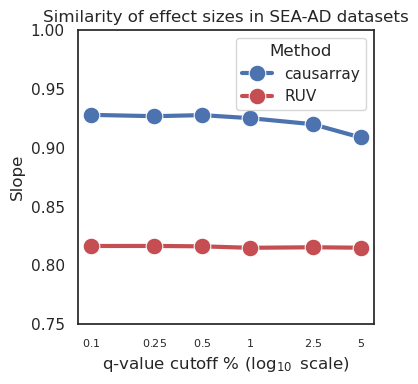

In [4]:
from matplotlib.ticker import FixedLocator, ScalarFormatter, FuncFormatter
# Function to format ticks in scientific notation with LaTeX
def scientific_format(x, pos):
    if x == 0.001:
        return r'$0.1$'
    elif x == 0.0025:
        return r'$0.25$'
    elif x == 0.005:
        return r'$0.5$'
    elif x == 0.01:
        return r'$1$'
    elif x == 0.025:
        return r'$2.5$'
    elif x == 0.05:
        return r'$5$'
    else:
        return f'{x:.0e}'

sns.set(font_scale=1., style="white")
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the data on the created axis
sns.lineplot(data=res, x='q_cutoff', y='slope', 
    hue='method', hue_order=['causarray', 'RUV'], 
    palette=[sns.palettes.color_palette()[0],sns.palettes.color_palette()[3]],
    lw=3., marker='o', markersize=12, ax=ax)

# Set the x-axis to a logarithmic scale
ax.set_xscale('log')

# Add titles and labels
ax.set_title('Similarity of effect sizes in SEA-AD datasets')
ax.set_xlabel(r'q-value cutoff % ($\log_{10}$ scale)')
ax.set_ylabel('Slope')

# Add a legend
ax.legend(title='Method')

# Set custom x-ticks
ax.set_xticks(q_cutoffs)

# Set custom x-ticks
ax.get_xaxis().set_major_formatter(FuncFormatter(scientific_format))
ax.tick_params(axis='x', labelsize=8)
ax.set_ylim(0.75, 1.)

# Show the plot
fig.tight_layout()
plt.savefig(path_result+'slope_vs_q_cutoff.pdf', bbox_inches='tight', dpi=300)

ruv 0.0
causarray 0.0006633499170812604


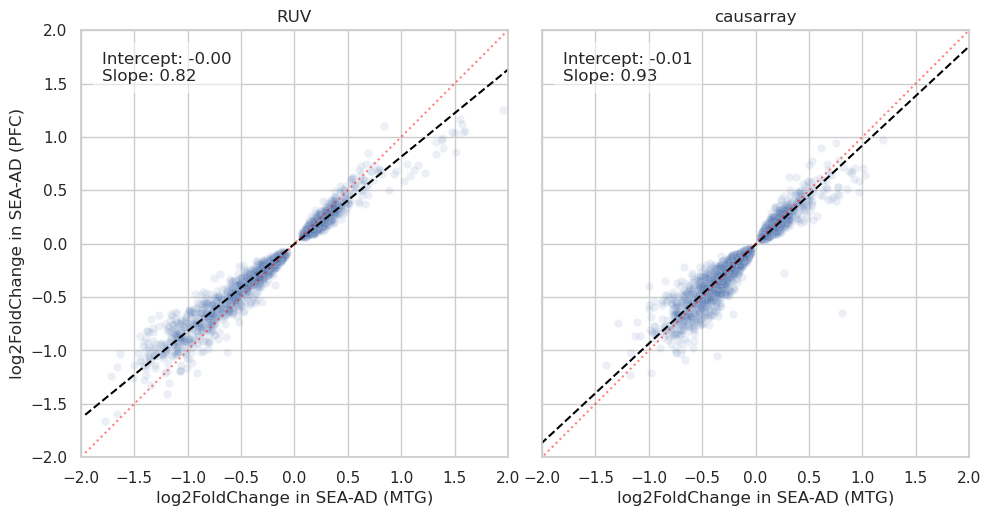

In [5]:
# Create scatter plots for each method
methods = df['method'].unique()
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, len(methods), figsize=(10, 5), sharex=True, sharey=True)

for ax, method in zip(axes, methods):
    # Filter significant genes
    significant_genes = df[(df['padj'] < 0.001)&(df['method']==method)&(df['dataset'].str.startswith('sea'))]

    # Identify common significant genes in both datasets
    common_genes = significant_genes.groupby(['gene_names']).filter(lambda x: x['dataset'].nunique() == 2)['gene_names'].unique()

    # Filter the dataframe to include only common significant genes
    common_significant_genes = significant_genes[significant_genes['gene_names'].isin(common_genes)]

    # Calculate average absolute log2FoldChange for each gene in each method
    avg_log2FC = common_significant_genes.groupby(['gene_names', 'method'])['log2FoldChange'].apply(lambda x: x.abs().mean()).reset_index()
    avg_log2FC.columns = ['gene_names', 'method', 'avg_abs_log2FC']

    # Select top 100 genes with largest average absolute log2FoldChange for each method
    top_genes = avg_log2FC.groupby('method').apply(lambda x: x.nlargest(20000, 'avg_abs_log2FC')).reset_index(drop=True)['gene_names']

    # Filter the original dataframe to include only the top genes
    filtered_df = common_significant_genes[common_significant_genes['gene_names'].isin(top_genes)]

    method_df = filtered_df[filtered_df['method'] == method]
    
    # Pivot the dataframe to have datasets as columns
    pivot_df = method_df.pivot(index='gene_names', columns='dataset', values='log2FoldChange').dropna()
    if method == 'ruv':
        pivot_df1 = pivot_df.copy()
    print(method, np.mean(pivot_df.iloc[:,0]*pivot_df.iloc[:,1] < 0))
    
    x=pivot_df.iloc[:, 0]
    y=pivot_df.iloc[:, 1]

    # Create a scatter plot for the method
    sns.scatterplot(x=x, y=y, ax=ax, alpha=0.1)
    
    X = sm.add_constant(x)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    intercept, slope = model.params
    
    # Plot the regression line
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, color='black', linestyle='--')

    ax.plot(x_vals, x_vals, color='red', alpha=0.5, linestyle=':')
    
    # Add labels for the intercept and slope
    ax.text(0.05, 0.95, f'Intercept: {intercept:.2f}\nSlope: {slope:.2f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.5, facecolor='white'))


    ax.set_title("RUV" if method == 'ruv' else "causarray")
    ax.set_xlabel(f"log2FoldChange in SEA-AD (MTG)")
    ax.set_ylabel(f"log2FoldChange in SEA-AD (PFC)")
    ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.tight_layout()
plt.savefig(path_result+'AD-scatterplot.pdf', bbox_inches='tight', dpi=300)

# Histogram of p-values

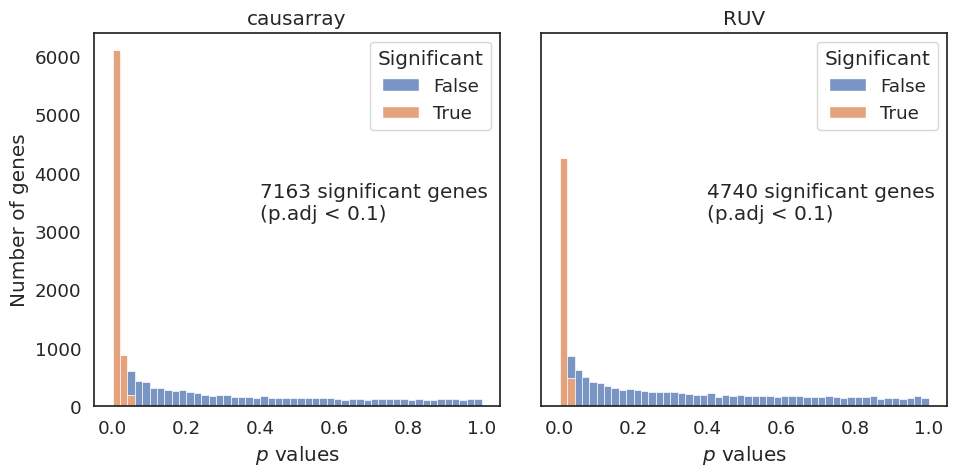

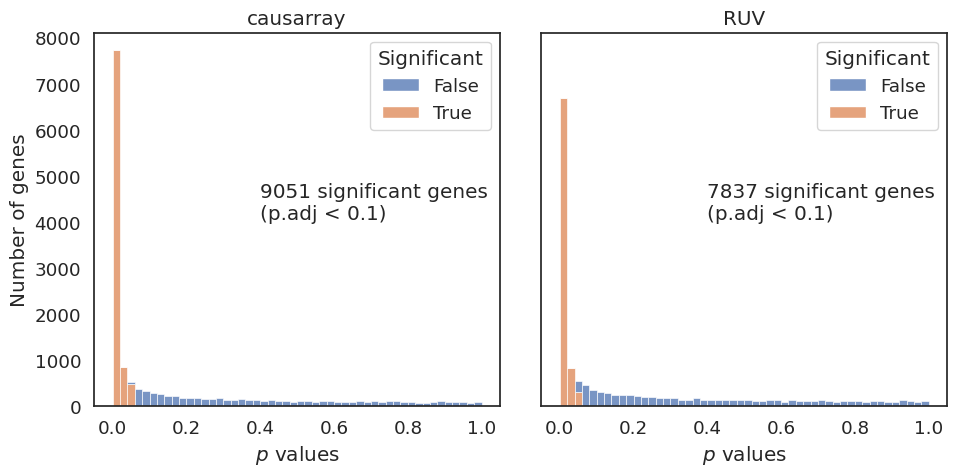

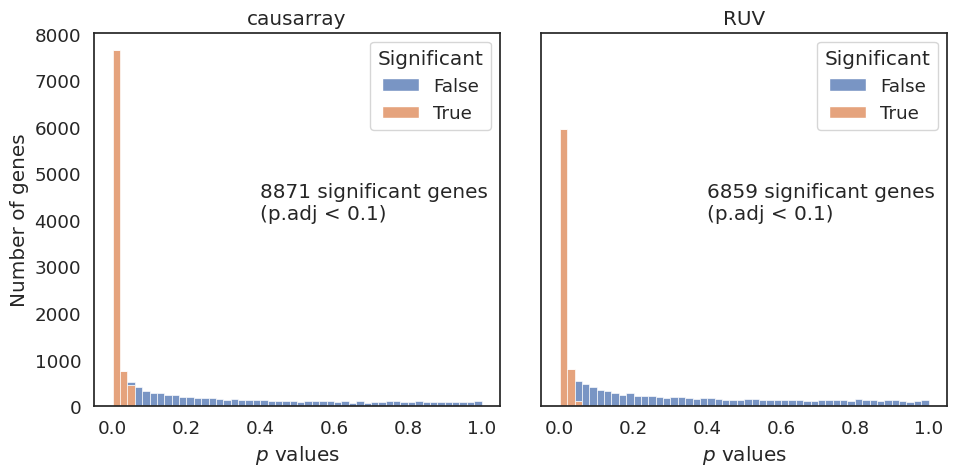

In [6]:
sns.set(font_scale=1.2, style="white")

x_axis = np.arange(-10, 10, 0.001)
method_list = ['causarray', 'RUV']
for i,dataset in enumerate(['rosmap', 'sea-MTG', 'sea-PFC']):
    fig, axes = plt.subplots(1,2,figsize=(10,5),sharey='row')

    df_list = []
    for j,method in enumerate(['causarray',  'ruv']):
        _df = results[method][i].copy()
        p_cutoff = _df[_df['padj']<0.1]['pvalue'].max()
        _df['Significant'] = _df['pvalue']<p_cutoff

        axes[j].set_title(method_list[j])
        sns.histplot(data=_df, x='pvalue', hue='Significant', multiple="stack", bins=50, ax=axes[j], color='grey', kde=False)
        # axes[j].hist(df['pvalue'], bins=50, density=False, range=[0,1])
        axes[j].set_xlabel('$p$ values')
        axes[j].text(0.4,axes[j].get_ylim()[1]*0.5, '{} significant genes\n(p.adj < 0.1)'.format(np.sum(_df['padj']<0.1)))
        
    axes[0].set_ylabel('Number of genes')
    fig.tight_layout()
    fig.savefig('{}stat_{}.pdf'.format(path_result, dataset), bbox_inches='tight', pad_inches=0, dpi=300)

# Propensity score

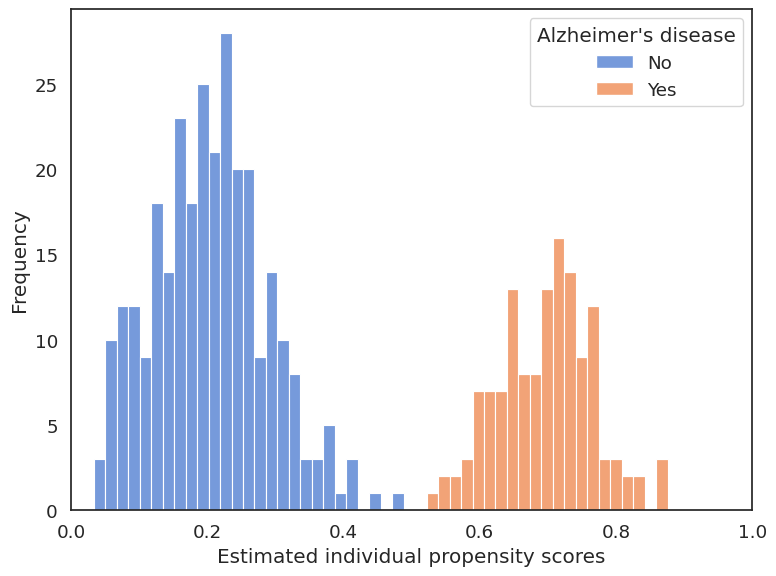

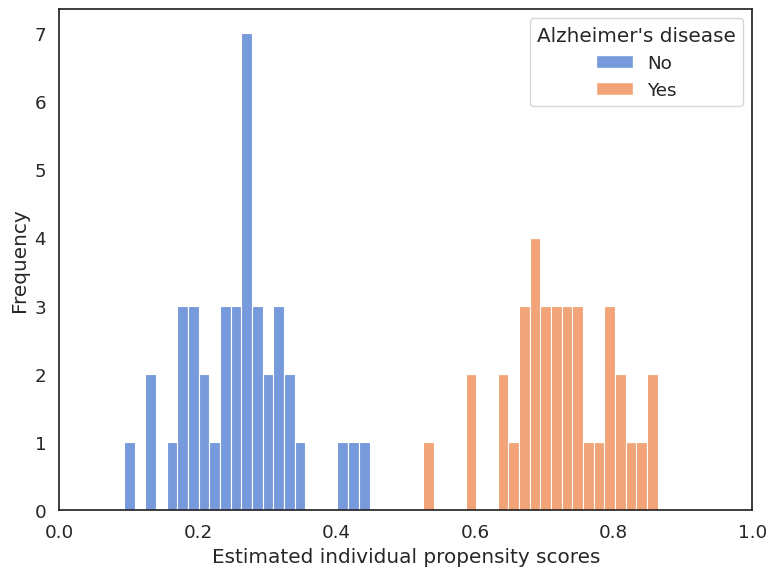

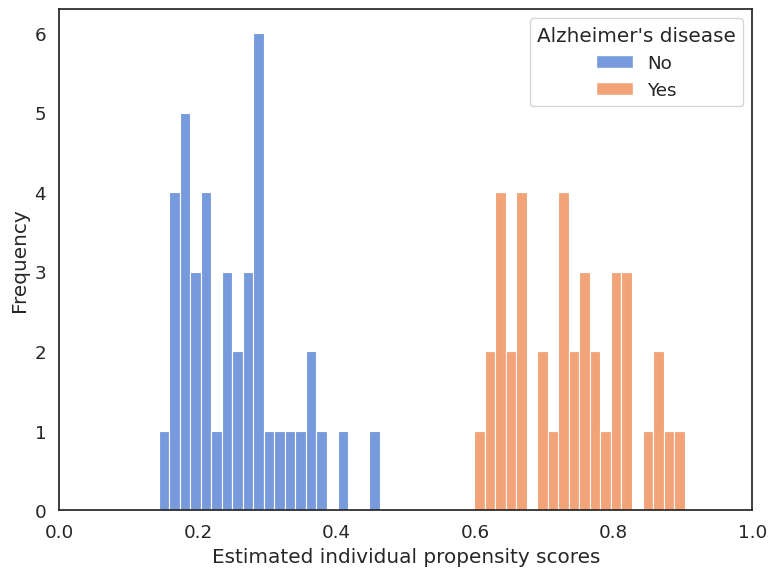

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy as sp
sys.path.append('../methods/')
from causarray import LFC


for dataset, path in zip(
    ['ROSMAP-AD', 'SEA-AD (PFC)', 'SEA-AD (MTG)'],
    ['ROSMAP-AD/results/','SEA-AD/results-PFC/', 'SEA-AD/results-MTG/']
    ):
    path = '../{}{}/DE/data/'.format(path,ps_model)
    pi = pd.read_csv(path+"pi.csv", index_col=0).values
    A = pd.read_csv(path+"A.csv", index_col=0).values

    sns.set(font_scale=1.2, style="white")
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    _df = pd.DataFrame({
        'value': pi[:,0],
        "Alzheimer's disease": ['No' if i==0 else 'Yes' for i in A]
    })
    sns.histplot(data=_df, x='value', hue="Alzheimer's disease", 
        multiple='stack', palette='muted', bins=50)
    ax.set_xlim([0,1])
    ax.set_xlabel('Estimated individual propensity scores')
    ax.set_ylabel('Frequency')


    # ax.legend(title="Alzheimer's disease", loc='upper right')
    fig.tight_layout()
    plt.savefig('{}pi_{}.pdf'.format(path_result, dataset), bbox_inches='tight', pad_inches=0, dpi=300)

# Upset plot

In [8]:
df = pd.DataFrame()
for method in ['ruv','causarray']:
    for i,dataset in enumerate(['rosmap', 'sea-MTG', 'sea-PFC']):
        _df = results[method][i].copy()
        _df.loc[:,'method'] = method
        _df.loc[:,'dataset'] = dataset
        df = pd.concat([df, _df], axis=0)

In [9]:
df[df['padj']<0.1].groupby(['method','dataset']).size()

method     dataset
causarray  rosmap     7163
           sea-MTG    9051
           sea-PFC    8871
ruv        rosmap     4740
           sea-MTG    7837
           sea-PFC    6859
dtype: int64

In [10]:
from upsetplot import UpSet, from_indicators

# Filter the dataframe for padj < 0.1
filtered_df = df[(df['padj'] < 0.1)]#&(df['log2FoldChange'].abs() > 0.1)]

# Create a combined method-dataset column
filtered_df.loc[:,'method_dataset'] = filtered_df['method'] + '_' + filtered_df['dataset']

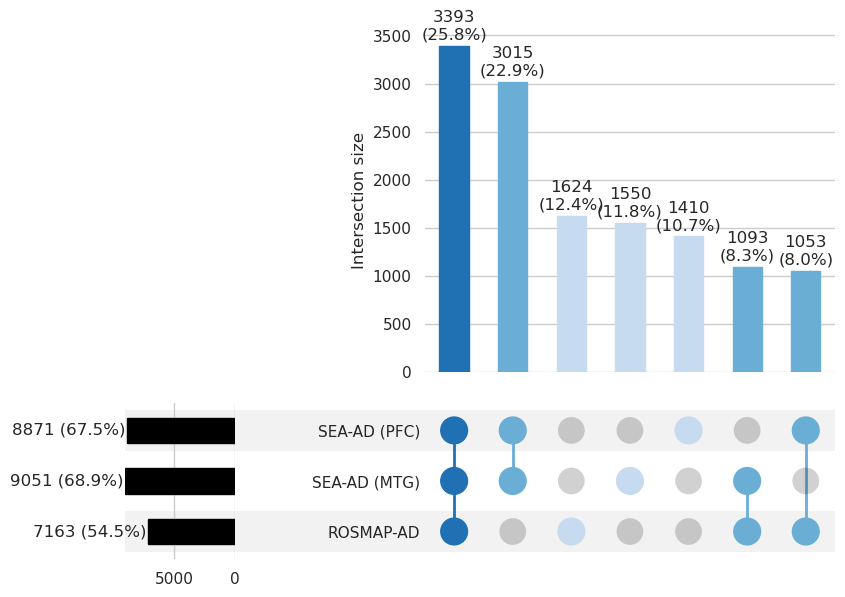

In [11]:
pivot_df = filtered_df.pivot_table(index='gene_names', columns='method_dataset', aggfunc='size', fill_value=0)
pivot_df = (pivot_df==1).iloc[:,:3]
pivot_df = pivot_df.loc[np.any(pivot_df, axis=1)]
pivot_df.columns = ['ROSMAP-AD', 'SEA-AD (MTG)', 'SEA-AD (PFC)']

sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False})

fig2 = plt.figure(figsize=(10, 5))
upset = UpSet(from_indicators(pivot_df).groupby(pivot_df.columns.tolist()).count(),
      sort_categories_by='input', sort_by='cardinality', show_percentages=True,
      element_size=55, show_counts=True)
for i in range(3):
    upset.style_subsets(min_degree=i+1, facecolor=sns.color_palette("Blues", 3)[i])
upset.plot(fig=fig2)
fig2.savefig('{}upset-causarray.pdf'.format(path_result), bbox_inches='tight', dpi=300)

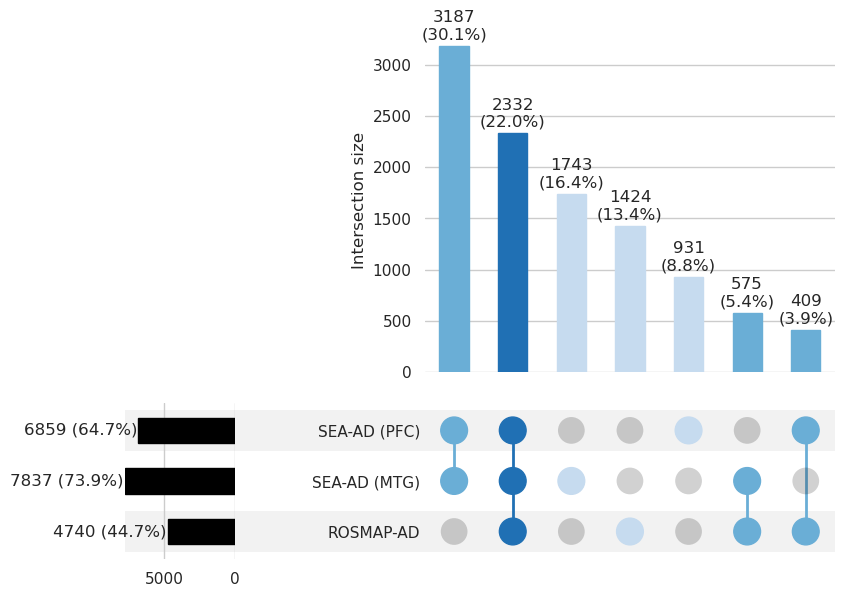

In [12]:
pivot_df = filtered_df.pivot_table(index='gene_names', columns='method_dataset', aggfunc='size', fill_value=0)
pivot_df = (pivot_df==1).iloc[:,3:]
pivot_df = pivot_df.loc[np.any(pivot_df, axis=1)]
pivot_df.columns = ['ROSMAP-AD', 'SEA-AD (MTG)', 'SEA-AD (PFC)']

sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False})

fig2 = plt.figure(figsize=(10, 5))
upset = UpSet(from_indicators(pivot_df).groupby(pivot_df.columns.tolist()).count(),
        sort_categories_by='input', sort_by='cardinality', show_percentages=True,
        element_size=55, show_counts=True)
for i in range(3):
    upset.style_subsets(min_degree=i+1, facecolor=sns.color_palette("Blues", 3)[i])
upset.plot(fig=fig2)
fig2.savefig('{}upset-ruv.pdf'.format(path_result), bbox_inches='tight', dpi=300)

# GO

In [13]:
df_go_sea_MTG_ruv = pd.read_csv('/home/jinandmaya/SEA-AD/results-MTG/{}/GO/GO_ruv.csv'.format(ps_model))
df_go_sea_MTG_causarray = pd.read_csv('/home/jinandmaya/SEA-AD/results-MTG/{}/GO/GO_causarray.csv'.format(ps_model))
df_go_sea_PFC_ruv = pd.read_csv('/home/jinandmaya/SEA-AD/results-PFC/{}/GO/GO_ruv.csv'.format(ps_model))
df_go_sea_PFC_causarray = pd.read_csv('/home/jinandmaya/SEA-AD/results-PFC/{}/GO/GO_causarray.csv'.format(ps_model))
df_go_rosmap_ruv = pd.read_csv('/home/jinandmaya/ROSMAP-AD/results/{}/GO/GO_ruv.csv'.format(ps_model))
df_go_rosmap_causarray = pd.read_csv('/home/jinandmaya/ROSMAP-AD/results/{}/GO/GO_causarray.csv'.format(ps_model))

results_go = dict()
results_go['ruv'] = (df_go_rosmap_ruv, df_go_sea_MTG_ruv, df_go_sea_PFC_ruv)
results_go['causarray'] = (df_go_rosmap_causarray, df_go_sea_MTG_causarray, df_go_sea_PFC_causarray)

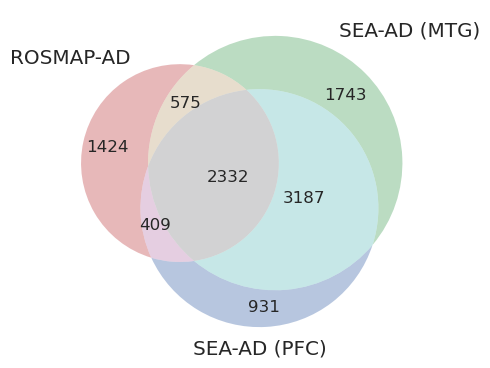

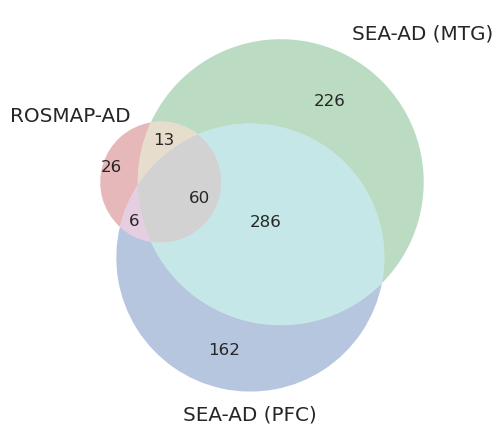

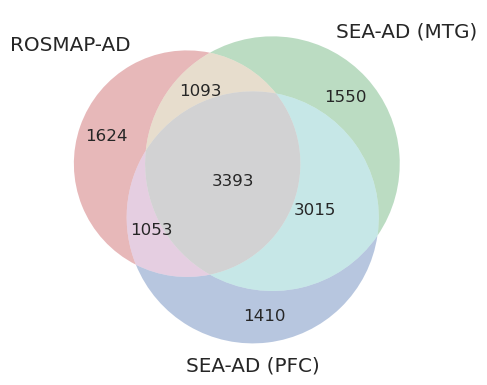

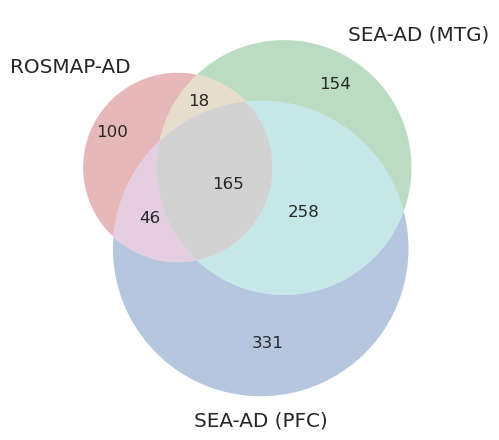

In [14]:
gene_sets = {}
go_terms_sets = {}
for method in ['ruv', 'causarray']:
    gene_sets[method] = [None,None,None]
    go_terms_sets[method] = [None,None,None]
    for i,dataset in enumerate(['rosmap', 'sea-MTG', 'sea-PFC']):
        _df = results[method][i]
        gene_sets[method][i] = set(_df[_df['padj']<0.1]['gene_names'])
        # gene_sets[method][i] = set(_df.sort_values('padj').head(100)['gene_names'])
        go_terms_sets[method][i] = set(results_go[method][i]['Description'])    

sns.set(font_scale=1., style="white")
for i, method in enumerate(['ruv', 'causarray']):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    venn3(gene_sets[method], set_labels=('ROSMAP-AD', 'SEA-AD (MTG)', 'SEA-AD (PFC)'), ax=axes)
    fig.tight_layout()
    fig.savefig(path_result+'AD-venn-DE-{}.pdf'.format(method), bbox_inches='tight', dpi=300)

    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    venn3(go_terms_sets[method], set_labels=('ROSMAP-AD', 'SEA-AD (MTG)', 'SEA-AD (PFC)'), ax=axes)
    fig.tight_layout()
    fig.savefig(path_result+'AD-venn-GO-{}.pdf'.format(method), bbox_inches='tight', dpi=300)

# CATE

In [15]:
import pickle
with open('../ROSMAP-AD/results/random_forest_cv/DE/data/result_CATE.pkl', 'rb') as f:
    res_cate = pickle.load(f)
# Access the objects
df = res_cate['df']
W_raw = res_cate['W_raw']
eta_0 = res_cate['eta_0']
eta_1 = res_cate['eta_1']
phi = res_cate['phi']
tvalues_init = df['stat']
pvals = df['pvalue']
qvals = df['padj']
res_vim = res_cate['res_vim']
id_cells = W_raw[:,-1] < 90

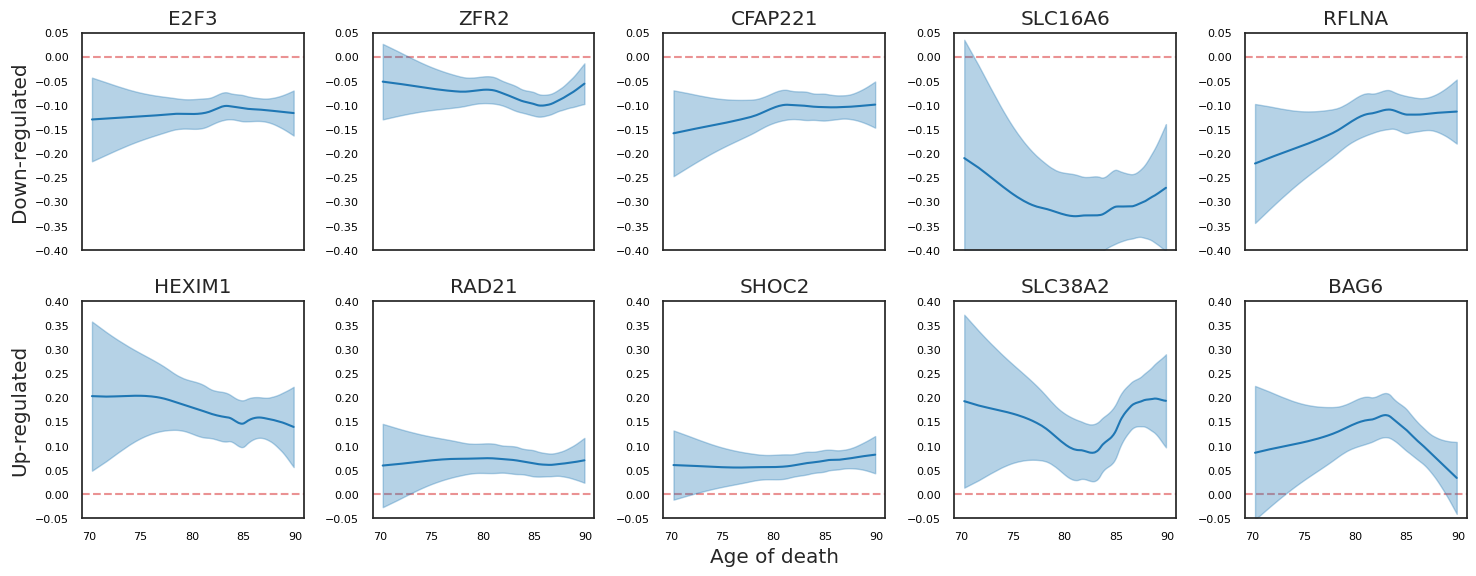

In [16]:
cov_names = ['pmi', 'Age of death']
i_cov = 1
cov_name = cov_names[i_cov]

ids = (df['padj']<0.05)&(qvals<0.05)#&(np.abs(df['tau'])>.1)
id_list =[ 
    np.where(ids)[0][np.argsort(tvalues_init[ids])][:5],
    np.where(ids)[0][np.argsort(tvalues_init[ids])][-5:][::-1]]    
    
sns.set(font_scale=1.2, style="white")
fig, axes = plt.subplots(2,5,figsize=(15,6), sharex=True, sharey=False)

for i in range(2):
    for j, id_gene in enumerate(id_list[i]):
        gene_name = df['gene_names'][id_gene]

        x = W_raw[id_cells][:,i_cov+2]
        # x = W[:,3]
        y = phi[id_cells][:,id_gene]

        lowess = res_vim['CATE'][i_cov,:,id_gene]
        ll = res_vim['CATE_lower'][i_cov,:,id_gene]
        ul = res_vim['CATE_upper'][i_cov,:,id_gene]
        # sns.lineplot(x=W[:,1], y=res_vim['CATE'][0,:,9])
        
        # axes[i,j].plot(x[np.argsort(x)], y[np.argsort(x)], 'o', color=sns.color_palette("tab10")[-1], alpha=0.1)
        axes[i,j].axhline(0, color=sns.color_palette("tab10")[3], linestyle='--', alpha=0.5, zorder=0)
        axes[i,j].plot(x[np.argsort(x)], lowess[np.argsort(x)], color=sns.color_palette("tab10")[0])
        axes[i,j].fill_between(x[np.argsort(x)],ll[np.argsort(x)],ul[np.argsort(x)], color=sns.color_palette("tab10")[0], alpha=.33)

        axes[i,j].set_ylim(np.quantile(y, 0.01), np.quantile(y, 0.99))
        # axes.set_xscale('log')
        if j == 0:
            axes[i,j].set_ylabel('Up-regulated' if i==1 else 'Down-regulated')
        if i == 1 and j==2:
            axes[i,j].set_xlabel(cov_name)
        axes[i, j].tick_params(axis='both', which='major', labelsize=8, labelcolor='black')

        axes[i,j].set_title(gene_name)
        
        if i==0:
            axes[i,j].set_ylim([-.4,0.05])
        else:
            axes[i,j].set_ylim([-0.05,.4])
fig.tight_layout()
plt.savefig(path_result+'CATE.pdf', bbox_inches='tight', dpi=300)        

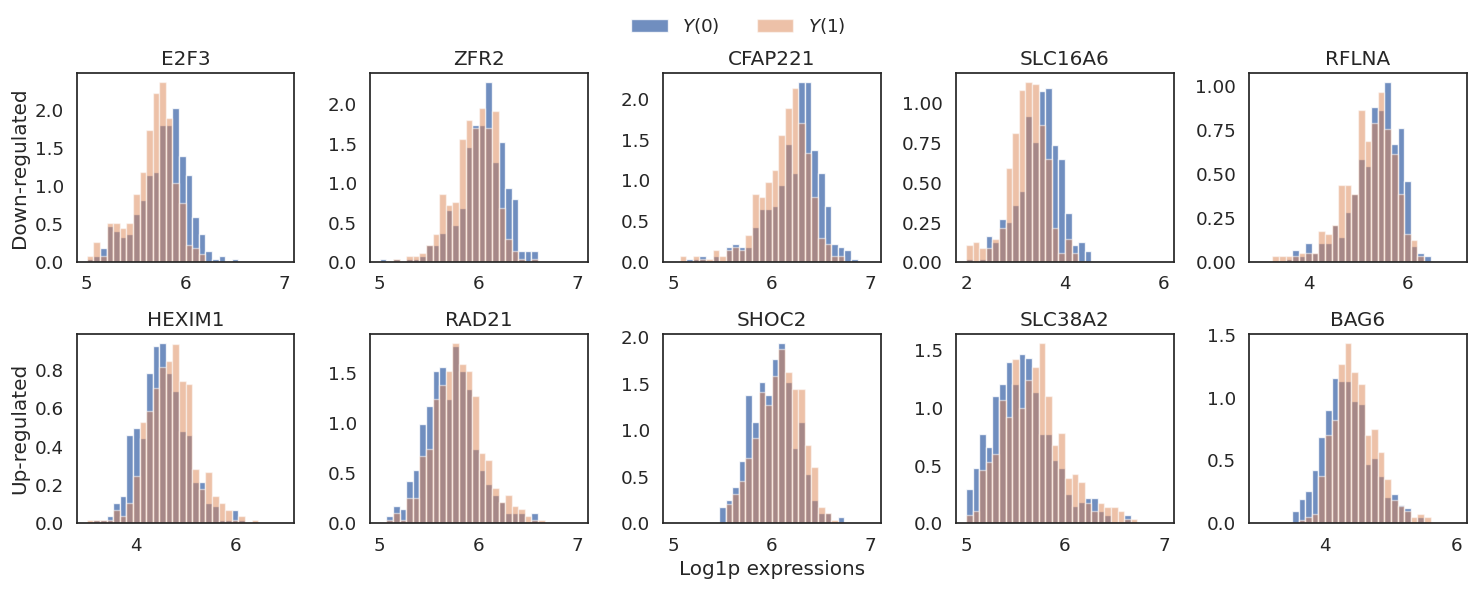

In [17]:
sns.set(font_scale=1.2, style="white")
fig, axes = plt.subplots(2,5,figsize=(15,6), sharey=False)

for i in range(2):
    for j, id_gene in enumerate(id_list[i]):
        gene_name = df['gene_names'][id_gene]
        range_low = 0 
        range_high = 6 if (i==0 and j==3) or (i==1 and j==4) else 7
        range_low = 2 if (i==0 and j==3) else (3 if (i==1 and j==0) or (j==4) else 5)
        # range_high = 6 if (i==0 and j==3) or (i==1 and j==4) else 7
        axes[i,j].hist(np.log1p(eta_0)[:,id_gene], bins=30, alpha=0.8, range=[range_low,range_high],
            label='$Y(0)$', density=True)
        axes[i,j].hist(np.log1p(eta_1)[:,id_gene], bins=30, alpha=0.5, range=[range_low,range_high],
            label='$Y(1)$', density=True)

        # axes[i,j].set_ylim(np.quantile(y, 0.01), np.quantile(y, 0.99))
        # axes.set_xscale('log')
        if j == 0:
            axes[i,j].set_ylabel('Up-regulated' if i==1 else 'Down-regulated')
        if i == 1 and j == 2:
            axes[i,j].set_xlabel('Log1p expressions')
        
        axes[i,j].set_title(gene_name)
# axes[0,0].set_xlim([2,7])        
axes[0,0].legend()
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[0,0].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig(path_result+'counterfactuals.pdf', bbox_inches='tight', dpi=300)